In [221]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
from scipy import stats
from collections import Counter

In [222]:
def SegIndex(pop, heigth, width):
    
    meanColor = pop.mean()
    
    
    numerator1 = pop.size  # Number of agents on the grid
    denominator1 = 0 
    numerator2 = 0
    denominator2 = 0
    
    for i in range(pop.size):
        yi = i//heigth
        xi = i - yi*width
        
        if(pop[yi, xi]!=0 ): 
            
            for j in range(pop.size):
                yj = j//heigth
                xj = j - yj*width
                
                if(pop[yj, xj]!=0 ):
                    if (yj in range(yi-1 if yi > 0 else yi, yi+2 if yi < len(pop)-1 else yi+1) and i!=j):
                        if (xj in range(xi-1 if xi > 0 else xi, xi+2 if xi < len(pop[0])-1 else xi+1)):
                            if (yj != xj):
                                denominator1 += 1
                                numerator2 += (pop[yi,xi] - meanColor)*(pop[yj,xj] - meanColor)
        denominator2 += (pop[yi,xi] - meanColor)*(pop[yi,xi] - meanColor)
            
            
                    
                    
    return (numerator1/denominator1)*(numerator2/denominator2)


In [223]:
class GridObject:
    
    def __init__ (self, x, y, empty):
        self.x = x
        self.y = y
        self.empty = empty # True for empty cell, False fo agent

In [224]:
adap_period = 3

class Agent(GridObject):
    
    def __init__(self, x, y, characteristic, tolerance, adapt):
        
        super().__init__(x, y, False)
        
        self.type = characteristic
        self.threshold = tolerance
        self.tMinority = 0
        self.tMajority = 0
        self.adapt = adapt
        
    def Adapt(self):
        
        if self.tMinority >= self.adapt and self.threshold >1 and self.adapt!=0:
            self.threshold -=1
        elif self.tMajority >= self.adapt and self.threshold >8 and self.adapt!=0:
            self.threshold +=1

In [246]:
nTypeComunities=2
probabilitiesType= [0.1,0.45,0.45]

class Grid():
    
    def __init__(self, width, heigth, vMinimum, vMaximum, fractionAdaptive):
        
        self.width = width
        self.heigth = heigth
        self.population = []
        
        for y in range(self.width):
            for x in range(self.heigth):

                random_number = np.random.choice(nTypeComunities+1, p=probabilitiesType)

                if random_number==0:
                    self.population.append(GridObject(x,y, True))
                else:
                    
                    tolerance = np.random.randint(vMinimum, vMaximum)
                    adapt = np.random.choice([0,3], p=[1-fractionAdaptive, fractionAdaptive])
                    
                    if random_number==1:
                        self.population.append(Agent(x, y, 1, tolerance, adapt))
                    elif random_number==2:
                        self.population.append(Agent(x, y, 2, tolerance, adapt))
    
    def getPopMatrix(self):
        popMatrix = np.zeros((self.heigth, self.width))
        
        for obj in self.population:
            if not obj.empty:
                popMatrix[obj.y, obj.x] = obj.type
        return popMatrix
    
    def getThreMatrix(self):
        threMatrix = np.zeros((self.heigth, self.width))
        
        for obj in self.population:
            if not obj.empty:
                threMatrix[obj.y, obj.x] = obj.threshold
        return threMatrix
    
    def countNeighbours(self, x, y):
        SameNeighbours=0
        neighbours=[]

        if (not self.population[x + y*self.width].empty):
            # If it is an agent, return neigh.s

            # The loop goes trhough all the neighbours and the agent itself
            for r in range(y-1 if y > 0 else y, y+2 if y < self.heigth -1 else y+1):
                for c in range(x-1 if x > 0 else x, x+2 if x < self.width -1 else x+1):
                    neighbours.append(self.population[r*self.width + c])

            # nr total of neighbours: minus the agent itself minus the empty spots
            TotalNeighbours = len([neighbor for neighbor in neighbours if not neighbor.empty ])- 1

            # nr SAMETYPE neighbours: minus the agent itself 
            SameNeighbours =  len([neighbor for neighbor in neighbours if not neighbor.empty and neighbor.type == self.population[x + y*self.width].type ])- 1

            # nr OPOSITETYPE neighbours: total neigh. minus the sametype neigh.
            OpositeNeighbours = TotalNeighbours - SameNeighbours

            return TotalNeighbours , SameNeighbours, OpositeNeighbours    

        else:
            # If it is an empty spot, return 000
            return 0 , 0, 0
        
    def replacePosition(self, agent):
        
        emptyCells = [emptyCell for emptyCell in self.population if emptyCell.empty]
        
        random_emptyCell = np.random.randint(len(emptyCells))
        
        posxEmptyCell = emptyCells[random_emptyCell].x
        posyEmptyCell = emptyCells[random_emptyCell].y
        
        emptyCells[random_emptyCell].x = agent.x
        emptyCells[random_emptyCell].y = agent.y
        
        self.population[agent.x + agent.y*self.width] = emptyCells[random_emptyCell]
        
        agent.x = posxEmptyCell
        agent.y = posyEmptyCell
        
        self.population[posxEmptyCell + posyEmptyCell*self.width] = agent
        
        
    
    def updateTimesMinoMajo(self):
        
        agents = [agent for agent in self.population if not agent.empty ]
        
        for agent in agents:
            TotalNeighbours , SameNeighbours, OpositeNeighbours = self.countNeighbours( agent.x, agent.y)
            
            agent.Adapt()
            
            if(TotalNeighbours != 0):
                percentagem = SameNeighbours/TotalNeighbours
                if(percentagem >= 0.5):
                    agent.tMinority = 0
                    agent.tMajority += 1
                elif(percentagem < 0.5):
                    agent.tMinority += 1
                    agent.tMajority = 0
            

In [247]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap

def PlottarThreshold(threMatrix, filename, title ):
    fig, ax = plt.subplots()
    colors = ListedColormap(["red", "orangered","lightcoral","lightsalmon", "lightskyblue","dodgerblue","cornflowerblue", "tab:blue", "darkblue"])
    
    ax.matshow(threMatrix, cmap=plt.cm.Blues)
    fig.colorbar(ax.matshow(threMatrix, cmap=plt.cm.RdBu, vmax=8, vmin=0))
    plt.title(title)
    plt.show()
    
    fig.savefig(filename, bbox_inches='tight', dpi=150)

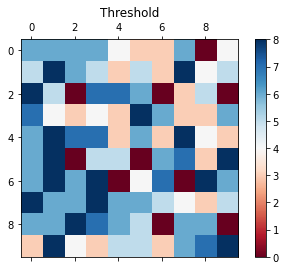

In [248]:
pop_treino = Grid(10,10, 3,9, 0.5)

len(pop_treino.population)

PlottarThreshold(pop_treino.getThreMatrix(), 'pape.pdf', 'Threshold')

In [249]:
from matplotlib.colors import ListedColormap

def PlottarPopulation(pop, filename, title ):
    fig, ax = plt.subplots()
    colors = ListedColormap(["white", "yellowgreen", "tab:blue"])
    ax.matshow(pop, cmap=colors, vmax=2, vmin=0)
    plt.title(title)
    plt.show
    fig.savefig(filename, bbox_inches='tight', dpi=150)

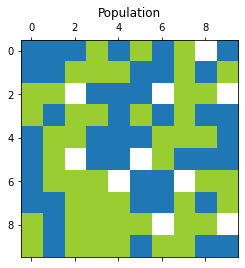

In [250]:
PlottarPopulation(pop_treino.getPopMatrix(), 'pape.pdf', 'Population')

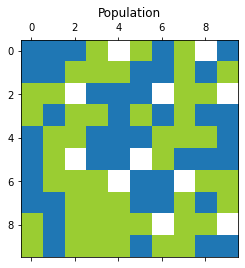

In [251]:
pop_treino.replacePosition(pop.population[4])
PlottarPopulation(pop_treino.getPopMatrix(), 'pape.pdf', 'Population')

In [259]:
def PlottarThresholdDist(grid, filename, title):
    
    #For each community type we need a vector that counts the amout of same community neighbours one agent has
    
    vec = np.zeros(9)
    for obj in grid.population:
        if not obj.empty:
            vec[int(obj.threshold)]+=1
    
#     fig1, ax1 = plt.subplots()
#     ax1.plot(vec, marker='o')
    
#     plt.xlabel('Threshold')
#     plt.ylabel('Nr of Agents')
#     plt.title(title)
#     plt.show()
    
#     fig1.savefig(filename, bbox_inches='tight', dpi=150)
    
    return vec

In [260]:
PlottarThresholdDist(pop_treino, 'pape.pdf', 'Threshold dist')

array([ 0.,  0.,  0., 17.,  8., 13., 26.,  9., 16.])

In [261]:
def Simulation(vMinimum, vMaximum, names, fraction):
    
    grid = Grid(50,50, vMinimum, vMaximum, fraction)
    
#     PlottarPopulation(grid.getPopMatrix(), names[0], 'Population')
#     PlottarThreshold(grid.getThreMatrix(), names[1], 'Threshold')
    
    seg_initial = SegIndex(grid.getPopMatrix(),50,50)
    seg_threshold_initial = SegIndex(grid.getThreMatrix(),50,50)
    
    print ("Initial index of segmentation: ", seg_initial)
    print ("Initial index of segmentation (threshold): ", seg_threshold_initial)
    
    vec=[]
    
    counter=0
    while(counter <= 1000):
        
        counter+=1 
        
        agents = [agent for agent in grid.population if not agent.empty]
        
        for agent in agents:
            
            TotalNeighbours , SameNeighbours, OpositeNeighbours = grid.countNeighbours(agent.x, agent.y)
            
            if agent.threshold > SameNeighbours or np.random.rand()<0.01:
                grid.replacePosition(agent)
        
        grid.updateTimesMinoMajo()
        
        if(counter%100==0):
            vec.append(PlottarThresholdDist(grid,'pape.pdf', 'meio Threshold'))
    
    PlottarPopulation(grid.getPopMatrix(), names[0], 'Population')
    PlottarThreshold(grid.getThreMatrix(), names[1], 'Threshold')
    
    seg_final = SegIndex(grid.getPopMatrix(),50,50)
    seg_threshold_final = SegIndex(grid.getThreMatrix(),50,50)
    
    print ("Final index of segmentation: ", seg_final)
    print ("Final index of segmentation (threshold): ", seg_threshold_final)
    
    return grid.getPopMatrix(), grid.getThreMatrix(), seg_initial, seg_final, seg_threshold_initial, seg_threshold_final, vec

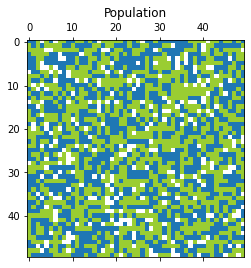

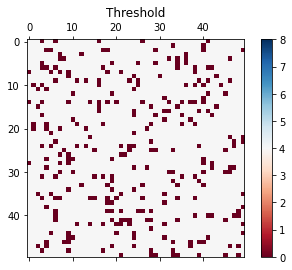

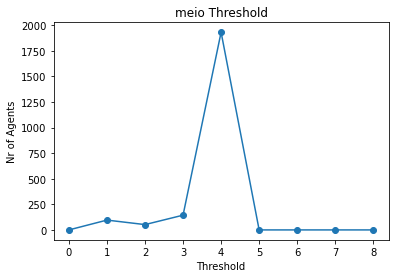

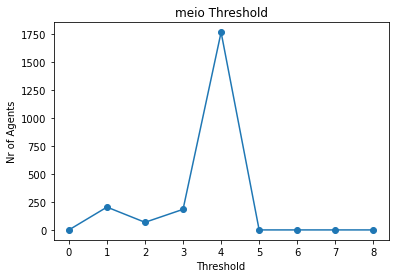

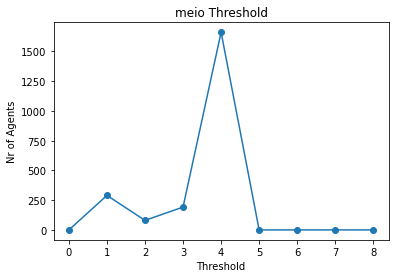

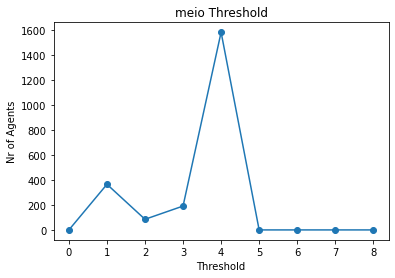

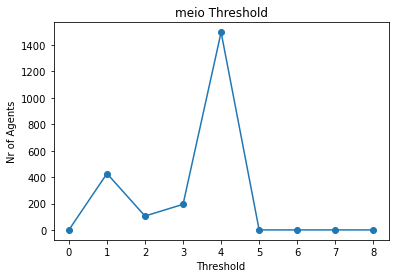

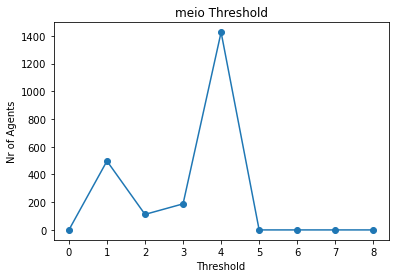

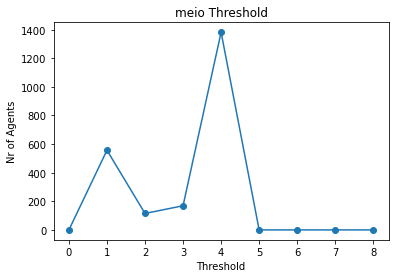

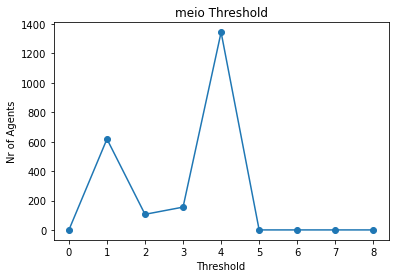

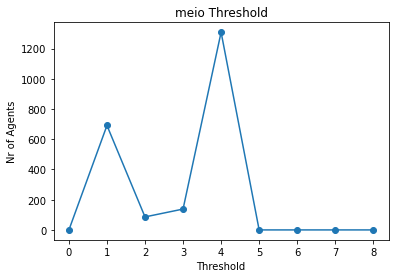

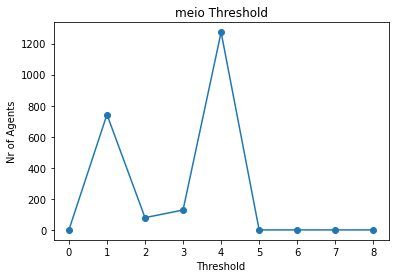

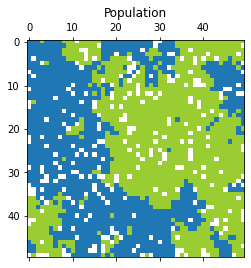

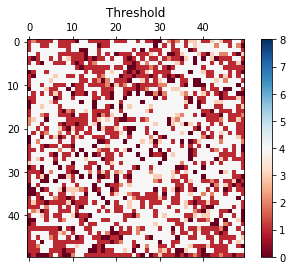

In [255]:
dados=[]
dados = Simulation(4,5,["pape.pdf","pape.pdf"], 0.5)

In [262]:
def Run (run_number, vMinimum, vMaximum):
    
    plot_names = ["pape.pdf","pape.pdf"]
    
    p_Adaptation = np.arange(0,1.05,0.1)
    
    df_results = pd.DataFrame(columns=['run_number',
                                       'p_adap', 
                                       'seg_pop_initial',
                                       'seg_pop_final', 
                                       'seg_threshold_initial',
                                       'seg_threshold_final',
                                       'mean_final_threshold',
                                       'mode_final_threshold',
                                       '2nd_mode_final_threshold'])

    
    for p_adap in p_Adaptation:
        print("--------------------- P_ADAP == ",p_adap )
        results = Simulation(vMinimum, vMaximum, plot_names, p_adap)
        
        # -------- MODE CALCULATION
        vals,counts = np.unique(results[1], return_counts=True)
        index = np.argmax(counts)
        mode_final_threshold = vals[index]
        
        # -------- 2ND MODE CALCULATION
        ctr = Counter(results[1].ravel())
        second_most_common_value, its_frequency = ctr.most_common(2)[1]
        
        df_results = df_results.append( {
            'run_number':                 run_number,
            'p_adap':                     p_adap,
            'seg_pop_initial':            results[2],
            'seg_pop_final':              results[3], 
            'seg_threshold_initial':      results[4],
            'seg_threshold_final':        results[5],
            'mean_final_threshold':       np.mean(results[1]),
            'mode_final_threshold':       mode_final_threshold,
            '2nd_mode_final_threshold':   second_most_common_value
        },ignore_index=True)
        
    return df_results

# Threshold : $n = 4$

--------------------- P_ADAP ==  0.0
Initial index of segmentation:  0.06575827283894123
Initial index of segmentation (threshold):  0.12714156898110207


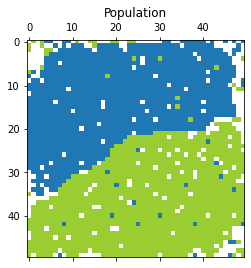

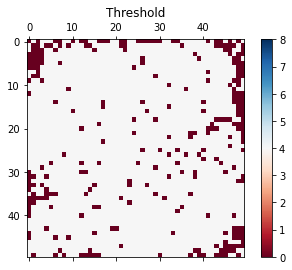

Final index of segmentation:  0.5858181243698696
Final index of segmentation (threshold):  0.12714156898110202
--------------------- P_ADAP ==  0.1
Initial index of segmentation:  0.045564969985198316
Initial index of segmentation (threshold):  0.12007168458780805


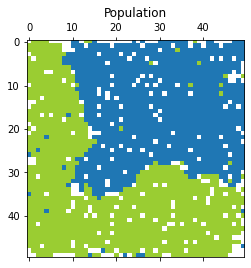

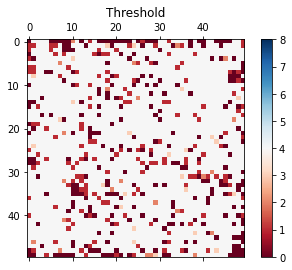

Final index of segmentation:  0.5849870647538309
Final index of segmentation (threshold):  0.1037522564325361
--------------------- P_ADAP ==  0.2
Initial index of segmentation:  0.04678259537773264
Initial index of segmentation (threshold):  0.10815602836881298


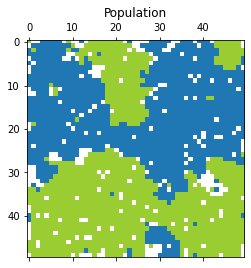

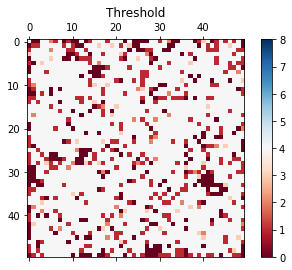

Final index of segmentation:  0.559015366777506
Final index of segmentation (threshold):  0.09366467392620917
--------------------- P_ADAP ==  0.30000000000000004
Initial index of segmentation:  0.06928279897058391
Initial index of segmentation (threshold):  0.12511251125110925


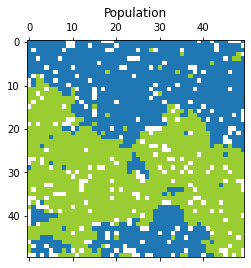

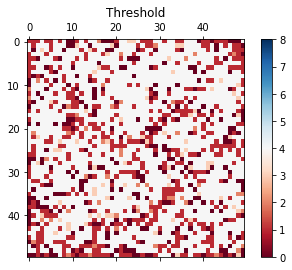

Final index of segmentation:  0.520385579488682
Final index of segmentation (threshold):  0.12821760234995266
--------------------- P_ADAP ==  0.4
Initial index of segmentation:  0.06893492478204316
Initial index of segmentation (threshold):  0.11706881143880692


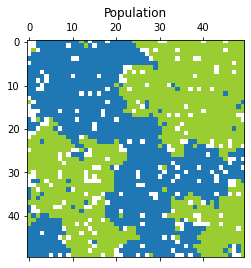

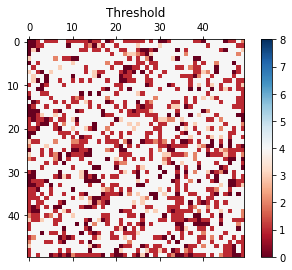

Final index of segmentation:  0.5220366446593832
Final index of segmentation (threshold):  0.09812683900210725
--------------------- P_ADAP ==  0.5
Initial index of segmentation:  0.03997716552147187
Initial index of segmentation (threshold):  0.09649122807019461


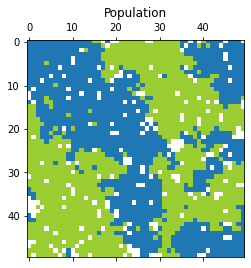

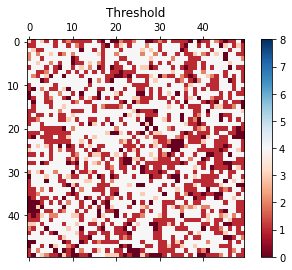

Final index of segmentation:  0.49765189994841197
Final index of segmentation (threshold):  0.09217535029927522
--------------------- P_ADAP ==  0.6000000000000001
Initial index of segmentation:  0.052673797075479575
Initial index of segmentation (threshold):  0.11061750333183204


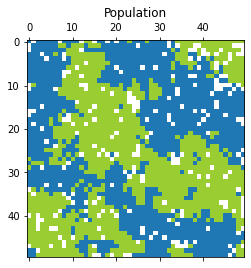

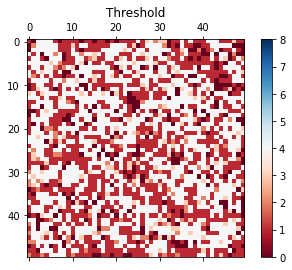

Final index of segmentation:  0.4447070824890535
Final index of segmentation (threshold):  0.0998549788729946
--------------------- P_ADAP ==  0.7000000000000001
Initial index of segmentation:  0.04373097350080741
Initial index of segmentation (threshold):  0.11408199643491178


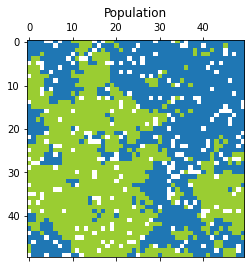

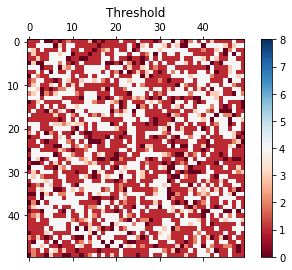

Final index of segmentation:  0.42935338725939604
Final index of segmentation (threshold):  0.0953235363035941
--------------------- P_ADAP ==  0.8
Initial index of segmentation:  0.05136159899559672
Initial index of segmentation (threshold):  0.10035211267604457


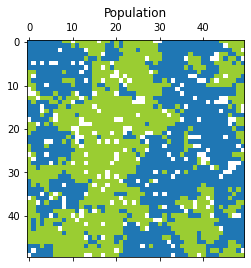

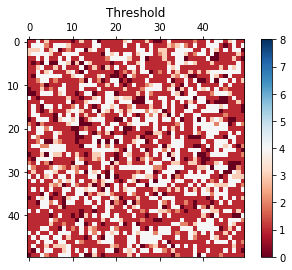

Final index of segmentation:  0.39209710238707823
Final index of segmentation (threshold):  0.08152482149699773
--------------------- P_ADAP ==  0.9
Initial index of segmentation:  0.046204525980928925
Initial index of segmentation (threshold):  0.10521662245801003


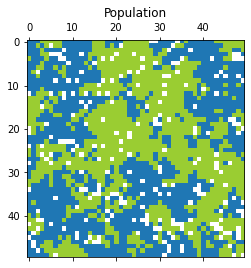

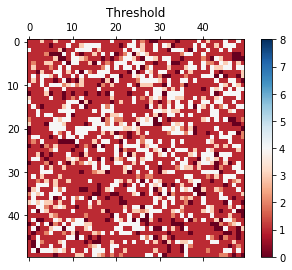

Final index of segmentation:  0.34356542175835697
Final index of segmentation (threshold):  0.09189884306741501
--------------------- P_ADAP ==  1.0
Initial index of segmentation:  0.05548803231847107
Initial index of segmentation (threshold):  0.11557340473004517


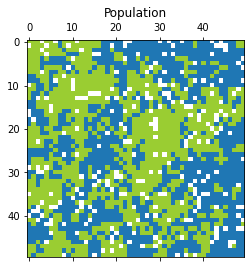

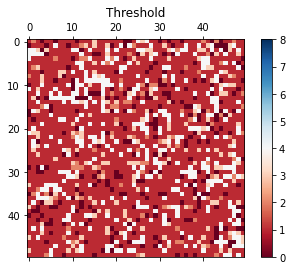

Final index of segmentation:  0.2788324432272058
Final index of segmentation (threshold):  0.08943245021519437
--------------------- P_ADAP ==  0.0
Initial index of segmentation:  0.03963558836061399
Initial index of segmentation (threshold):  0.09601052170103742


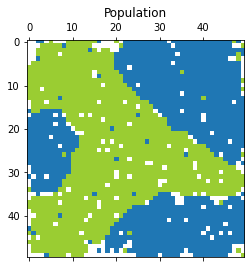

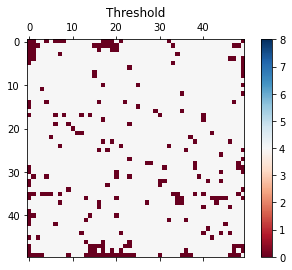

Final index of segmentation:  0.5961585223307235
Final index of segmentation (threshold):  0.09601052170103587
--------------------- P_ADAP ==  0.1
Initial index of segmentation:  0.04961860362486929
Initial index of segmentation (threshold):  0.10424028268551126


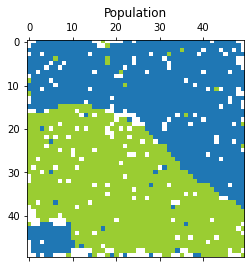

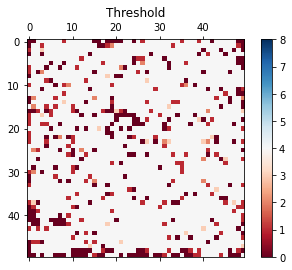

Final index of segmentation:  0.5958787325392205
Final index of segmentation (threshold):  0.09030181993044964
--------------------- P_ADAP ==  0.2
Initial index of segmentation:  0.041657000574227124
Initial index of segmentation (threshold):  0.10717449069972697


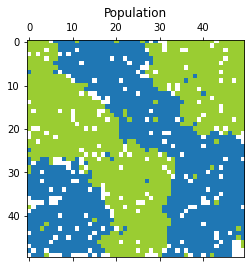

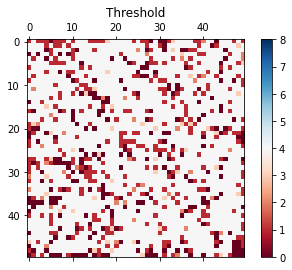

Final index of segmentation:  0.5547847009101077
Final index of segmentation (threshold):  0.08772315222093162
--------------------- P_ADAP ==  0.30000000000000004
Initial index of segmentation:  0.05660856326015034
Initial index of segmentation (threshold):  0.10717449069972682


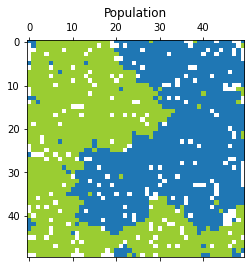

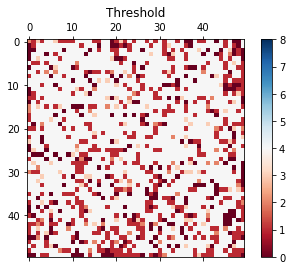

Final index of segmentation:  0.5607815502837502
Final index of segmentation (threshold):  0.09641328032460157
--------------------- P_ADAP ==  0.4
Initial index of segmentation:  0.0408755328095947
Initial index of segmentation (threshold):  0.10035211267604453


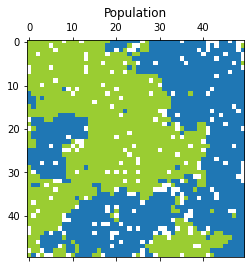

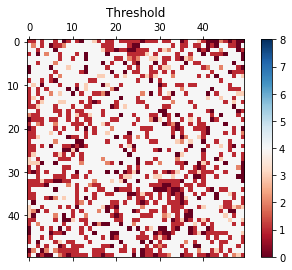

Final index of segmentation:  0.5430711028747038
Final index of segmentation (threshold):  0.09786412153515667
--------------------- P_ADAP ==  0.5
Initial index of segmentation:  0.06236177837774654
Initial index of segmentation (threshold):  0.1116051578479428


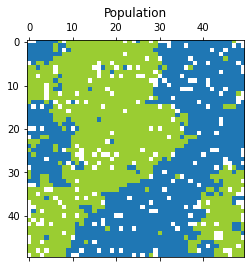

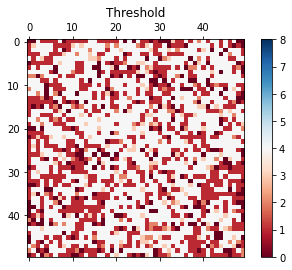

Final index of segmentation:  0.5051409876447154
Final index of segmentation (threshold):  0.10508571127425458
--------------------- P_ADAP ==  0.6000000000000001
Initial index of segmentation:  0.05294133998313369
Initial index of segmentation (threshold):  0.10180696341999308


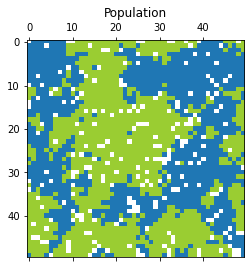

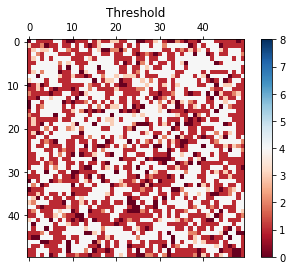

In [ ]:
df_overall = pd.DataFrame(columns=['run_number',
                                   'p_adap', 
                                   'seg_pop_initial',
                                   'seg_pop_final', 
                                   'seg_threshold_initial',
                                   'seg_threshold_final',
                                   'mean_final_threshold',
                                   'mode_final_threshold',
                                   '2nd_mode_final_threshold'])

for run in range(5):
    dfResults = Run(run, 4, 5)
    df_overall = df_overall.append(dfResults)

In [ ]:
df_overall.to_csv(r'df_overall.csv', index = False)
df_overall.tail()

In [ ]:
#--------------------
#   Fazer as médias com todas as runs
#--------------------

read_overall = pd.read_csv('df_overall.csv', delimiter = ',')
#read_overall 

sum_up = pd.DataFrame(columns=[
                            'p_adap', 
                            'seg_pop_initial',
                            'seg_pop_final', 
                            'seg_threshold_initial',
                            'seg_threshold_final',
                            'mean_final_threshold',
                            'mode_final_threshold',
                            '2nd_mode_final_threshold'])

for p in np.arange(0,1.05,0.1):
    p_overall = read_overall.loc[(read_overall['p_adap']>= p - 0.01) & (read_overall['p_adap']<= p + 0.01)]
    
    sum_up = sum_up.append({'p_adap':                   p, 
                            'seg_pop_initial':          p_overall['seg_pop_initial'].mean(),
                            'seg_pop_final':            p_overall['seg_pop_final'].mean(), 
                            'seg_threshold_initial':    p_overall['seg_threshold_initial'].mean(),
                            'seg_threshold_final':      p_overall['seg_threshold_final'].mean(),
                            'mean_final_threshold':     p_overall['mean_final_threshold'].mean(),
                            'mode_final_threshold':     p_overall['mode_final_threshold'].mean(),
                            '2nd_mode_final_threshold': p_overall['2nd_mode_final_threshold'].mean()
     },ignore_index=True)
    
sum_up

# Threshold : $n \in [4,8]$

In [ ]:
df_overall_BroadenThres = pd.DataFrame(columns=['run_number',
                                       'p_adap', 
                                       'seg_pop_initial',
                                       'seg_pop_final', 
                                       'seg_threshold_initial',
                                       'seg_threshold_final',
                                       'mean_final_threshold',
                                       'mode_final_threshold',
                                       '2nd_mode_final_threshold'])

for run in range(1):
    dfResults = Run(run, 4, 8)
    df_overall_BroadenThres = df_overall_BroadenThres.append(dfResults)

In [ ]:
df_overall_BroadenThres.to_csv(r'df_overall_threshold.csv', index = False)
df_overall_BroadenThres.tail()

In [ ]:
#--------------------
#   Fazer as médias com todas as runs
#--------------------

read_overall_BroadenThres = pd.read_csv('df_overall_threshold.csv', delimiter = ',')
#read_overall 

sum_up_BroadenThres = pd.DataFrame(columns=[
                            'p_adap', 
                            'seg_pop_initial',
                            'seg_pop_final', 
                            'seg_threshold_initial',
                            'seg_threshold_final',
                            'mean_final_threshold',
                            'mode_final_threshold',
                            '2nd_mode_final_threshold'])

for p in np.arange(0,1.05,0.1):
    p_overall_BroadenThres = read_overall_BroadenThres.loc[read_overall['p_adap']== p]
    
    sum_up_BroadenThres = sum_up_BroadenThres.append({'p_adap':                   p, 
                            'seg_pop_initial':          p_overall_BroadenThres['seg_pop_initial'].mean(),
                            'seg_pop_final':            p_overall_BroadenThres['seg_pop_final'].mean(), 
                            'seg_threshold_initial':    p_overall_BroadenThres['seg_threshold_initial'].mean(),
                            'seg_threshold_final':      p_overall_BroadenThres['seg_threshold_final'].mean(),
                            'mean_final_threshold':     p_overall_BroadenThres['mean_final_threshold'].mean(),
                            'mode_final_threshold':     p_overall_BroadenThres['mode_final_threshold'].mean(),
                            '2nd_mode_final_threshold': p_overall_BroadenThres['2nd_mode_final_threshold'].mean()
     },ignore_index=True)
    
sum_up_BroadenThres

# Changing the percentage of empty places: empty = 1% instead of 10%

--------------------- P_ADAP ==  0.0


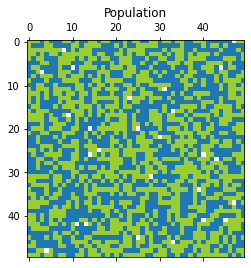

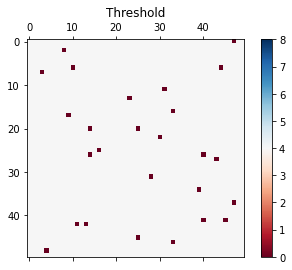

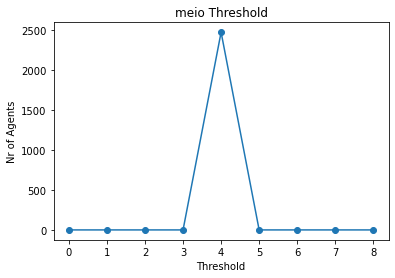

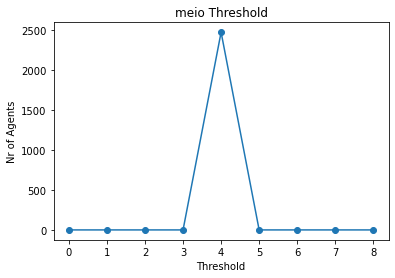

KeyboardInterrupt: 

In [244]:
probabilitiesType= [0.01,0.495,0.495]

# ----------------------------
#  COMPARE WITH n=4
# ----------------------------
df_overall_Empty = pd.DataFrame(columns=['run_number',
                                   'p_adap', 
                                   'seg_pop_initial',
                                   'seg_pop_final', 
                                   'seg_threshold_initial',
                                   'seg_threshold_final',
                                   'mean_final_threshold',
                                   'mode_final_threshold',
                                   '2nd_mode_final_threshold'])

for run in range(5):
    dfResults = Run(run, 4, 5)
    df_overall_Empty = df_overall_Empty.append(dfResults)